<a href="https://colab.research.google.com/github/sjut/DPO_Materials/blob/master/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5%20%D0%B7%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D1%8F/NER/food_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Извлечение информации правлами
##Продолжение FOOD
Для извлечения структурированной информации из неструткурированных текстов существуют специальные системы, основанные на правилах.\
Обычно система состоит из:
правила + гезетёры (или газетиры gazetteer)\
*газетеры* - специальные списки - например, списики названий всех организаций, которые должна извлекать система; списки продуктов для извлечения ингредиентов из рецептов и т.п.\
Формально система правил может быть реализована как система конченых преобразователей (Gate), либо как система контекстно-свободных грамматик

[Yargy](https://yargy.readthedocs.io/ru/latest/) — библиотека для извлечения структурированной информации из текстов на русском языке. Правила описываются контекстно-свободными грамматиками и словарями ключевых слов (газетерами).\

Банк готовых правил для имён, дат, адресов и других сущностей доступен в репозитории [Natasha](https://github.com/natasha/natasha).


In [1]:
#устанавливаем yargy - Yargy — библиотека для извлечения структурированной информации из текстов на русском языке. Правила описываются контекстно-свободными грамматиками и словарями ключевых слов. 
!pip install yargy
!pip install ipymarkup #Collection of NLP visualizations for NER and syntax tree markup.

     |████████████████████████████████| 51kB 3.0MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 7.1MB 8.4MB/s 


In [2]:
#клонируем папку гитхабе yargy - пример про извлечение данных из рецептов приготовления еды 04_food
%cd /content
!git clone https://github.com/natasha/yargy-examples.git
%cd yargy-examples/04_food

/content
Cloning into 'yargy-examples'...
remote: Enumerating objects: 2087, done.
remote: Total 2087 (delta 0), reused 0 (delta 0), pack-reused 2087
Receiving objects: 100% (2087/2087), 6.25 MiB | 3.75 MiB/s, done.
Resolving deltas: 100% (118/118), done.
/content/yargy-examples/04_food


In [0]:
# Модуль glob находит все пути, совпадающие с заданным шаблоном в соответствии с правилами, используемыми оболочкой Unix.
from glob import glob

# стандартизуем тире,  заменяем (убираем) спецсиволы (неразрывные пробелы, мягкие переносы) и т.п.  

def make_translation(source, target):
    assert len(source) == len(target)
    return {
        ord(a): ord(b)
        for a, b in zip(source, target)
    }


DASHES_TRANSLATION = make_translation(
    '‑–—−',
    '----'
)


def preprocess(text):
    text = text.replace('\xa0', ' ')
    text = text.replace('\xad', '')
    text = text.translate(DASHES_TRANSLATION)
    return text

#считываем тексты из папки с текстами (файлы с расширением .txt) и кладем их в список
texts = []
for path in sorted(glob('texts/*.txt')):
    with open(path) as file:
        text = file.read()
        text = preprocess(text)
        texts.append(text)

In [4]:
#проверяем, что записалось в список, сколько текстов считалось
print(texts[0])
len(texts)

Салат с ананасами и курицей 🍍

Ингредиенты:

● Филе куриной грудки 1 шт.
● Шампиньоны 300 г
● Кукуруза консервированная 1 банка
● Сыр 200 г
● Лук репчатый 1 головка
● Чеснок 2 зубчика
● Ананас консервированный 1 банка
● Майонез по вкусу

Приготовление:

1. Обжарить грибы с луком с добавить немного соли. Старайтесь не резать грибы слишком мелко.
2. Отварить куриную грудку без кожи, нарезать кусочками и добавить к ней консервированную кукурузу.
3. Сыр также нарезать маленькими кубиками или натереть на крупной терке. Добавить к курице с кукурузой.
4. Смешать все ингредиенты с консервированным ананасом и заправить салат майонезом с чесноком.

Приятного аппетита!


1000

In [5]:
from random import seed, sample
#случайным образом выбираем тексты и смотрим, как они устроены
seed(40)
for text in sample(texts, 2):
    print(text)
    print('---' * 10)

Мексиканский суп с курицей

Нам потребуется:

Куриная грудка - 1 шт.,
Лук репчатый - 1 шт.,
Красная фасоль консервированная - 1 банка,
Вермишель - 50 г,
Кукуруза замороженная - 100 г,
Укроп - по вкусу,
Соль - по вкусу,
Молотый острый красный перец - по вкусу.

Из куриной грудки сварите бульон, достаньте мясо, отделите от костей и мелко нарежьте.

Лук мелко нашинкуйте. В глубоком сотейнике разогрейте растительное масло и обжарьте лук до прозрачности.

Добавьте к луку курицу и обжаривайте несколько минут. С фасоли слейте жидкость. Переложите фасоль в сотейник, добавьте молотый перец по вкусу, перемешайте и продолжайте обжаривать.

Залейте в сотейник куриный бульон, посолите по вкусу и варите 5 мин. Добавьте вермишель и кукурузу, варите еще 5 минут, затем накройте крышкой и снимите с огня.

Дайте супу настояться. Мелко нарубите укроп. Подавайте суп с укропом и кукурузными чипсами.
------------------------------
Мясной пирог

Ингредиенты:
для теста:
сливочное масло - 1/2 стак
сметана - 1 с

Эвристики: строки с ингредиентами короткие (пусть не больше 50 символов) и содержат числа 

In [0]:
import re

#функция, которая отбирает строки с ингредтиентами
def find_ingredient_sections(text):
    return re.findall(r'ингредиенты:(.+?)приготовление', text, re.I | re.S)

#проверяем длину строки и наличие числа
def maybe_ingredient(line):
    match = re.search(r'\d', line)
    size = len(line) <= 50
    return match and size

lines = []

#в переменную lines (список из строк) записываем только строки длиной меньше 50 символов, содержащих число
for text in texts:
    sections = find_ingredient_sections(text)
    for section in sections:
        for line in section.splitlines():
            if maybe_ingredient(line):
                lines.append(line)

In [7]:
print(lines[0])

● Филе куриной грудки 1 шт.


In [8]:
seed(14)
sample(lines, 20)

['● Оливковое масло - 2 ст. л.',
 'Молоко 1% - 100 г ',
 '- Морковь 2 - 3 шт.',
 'творог - 500 г,',
 '2 яйца,',
 '* 3/4 стакана холодной кипяченой воды',
 '• сыр - 100 г.',
 '1 нарезанный красный перец',
 '230 г кокосового или тростникового сахара ',
 'Яйцо - 3 шт.',
 'Сок лайма - 2 Ст. ложки',
 '● Мука - 100 г.',
 'Сметана - 50 г',
 '● Бананы - 3 шт.',
 'ананасы консервированные - 1 банка ',
 '● Сыр твердый 30 гр.',
 '500 мл растительного масла ',
 '5) соль, растительное масло для пассеровки овощей.',
 '5 средних варёных картофелин ',
 '● 3-5 зубчиков чеснока; ']

#Грамматика
контекстно-свободная грамматика\
правила состоят из предикатов\
импортируем конструктор правил, импортируем предикаты

In [0]:
from IPython.display import display

# pip install ipymarkup
from ipymarkup import show_markup, AsciiMarkup

from yargy import (
    Parser,
    or_, rule
)
from yargy.pipelines import morph_pipeline
from yargy.predicates import (
    eq, in_, dictionary,
    type, gram, normalized
)
from yargy.tokenizer import MorphTokenizer
from yargy import interpretation as interp
from yargy.interpretation import fact, attribute

In [27]:
#смотрим, что возвращает токенайзер
from yargy.tokenizer import MorphTokenizer

TOKENIZER = MorphTokenizer()
print(list(TOKENIZER('столовых')))
#list(TOKENIZER('консервированного'))
#list(TOKENIZER('5 средних варёных картофелин'))
#list(TOKENIZER('3/4 стакана холодной кипяченой воды'))
list(TOKENIZER('2 ст. ложки'))

[MorphToken('столовых', [0, 8), 'RU', [Form('столовый', Grams(ADJF,gent,plur)), Form('столовый', Grams(ADJF,accs,anim,plur)), Form('столовый', Grams(ADJF,loct,plur)), Form('столовая', Grams(NOUN,femn,gent,inan,plur)), Form('столовая', Grams(NOUN,femn,inan,loct,plur))])]


[Token('2', [0, 1), 'INT'),
 MorphToken('ст',
            [2, 4),
            'RU',
            [Form('ст', Grams(Abbr,Fixd,NOUN,femn,inan,nomn,sing)),
             Form('ст', Grams(Abbr,Fixd,NOUN,femn,gent,inan,sing)),
             Form('ст', Grams(Abbr,Fixd,NOUN,datv,femn,inan,sing)),
             Form('ст', Grams(Abbr,Fixd,NOUN,accs,femn,inan,sing)),
             Form('ст', Grams(Abbr,Fixd,NOUN,ablt,femn,inan,sing)),
             Form('ст', Grams(Abbr,Fixd,NOUN,femn,inan,loct,sing)),
             Form('ст', Grams(Abbr,Fixd,NOUN,femn,inan,nomn,plur)),
             Form('ст', Grams(Abbr,Fixd,NOUN,femn,gent,inan,plur)),
             Form('ст', Grams(Abbr,Fixd,NOUN,datv,femn,inan,plur)),
             Form('ст', Grams(Abbr,Fixd,NOUN,accs,femn,inan,plur)),
             Form('ст', Grams(Abbr,Fixd,NOUN,ablt,femn,inan,plur)),
             Form('ст', Grams(Abbr,Fixd,NOUN,femn,inan,loct,plur))]),
 Token('.', [4, 5), 'PUNCT'),
 MorphToken('ложки',
            [6, 11),
            'RU',
        

In [66]:
#правило контекстно-свободной грамматики
R = rule('a', 'b')
R.normalized.as_bnf

R0 -> 'a' 'b'


[0,8) - [0 - номер первого символа токена, ) - номер пробела после токена 

In [42]:
line = "2 стакана крупы, 2 кг муки"
Rule = rule(eq("2")) #предикат eq - точное совпадение
parser = Parser(Rule)
matches = parser.findall(line)
spans = [_.span for _ in matches] #выдает позиции найденных спанов
print(spans)
show_markup(line, spans) # на вход принимает текст и список спанов, подсвечивает спаны

[[0, 1), [17, 18)]


BoxMarkup('2 стакана крупы, 2 кг муки', [Span(0, 1, None), Span(17, 18, None)])

[[0, 11), [19, 23)]


BoxMarkup('10 стаканов крупы, 2 кг муки',
          [Span(0, 11, None), Span(19, 23, None)])

Match([Token('10', [0, 2), 'INT'), MorphToken('стаканов', [3, 11), 'RU', [Form('стакан', Grams(NOUN,gent,inan,masc,plur))])], [0, 11))


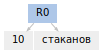

In [60]:
line = "10 стаканов крупы, 2 кг муки"
INT = type('INT') #создадим предикат - предикат принимает название типа
NOUN = gram('NOUN')
Rule = rule(INT, NOUN)
parser = Parser(Rule)
matches = parser.findall(line)
spans = [_.span for _ in matches] #выдает позиции найденных спанов
print(spans)
show_markup(line, spans) # на вход принимает текст и список спанов, подсвечивает спаны
#результат работы парсера - дерево разбора
match = list(parser.findall(line))
print(match[0])
match[0].tree.as_dot


Match([Token('10', [0, 2), 'INT'), MorphToken('стаканов', [3, 11), 'RU', [Form('стакан', Grams(NOUN,gent,inan,masc,plur))])], [0, 11))


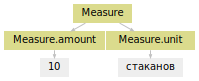

In [77]:
#собираем факт
#структурированное представление: для этого существует система интепретации
#создаем объект Measure
Measure = fact(
    'Measure',
    ['amount', 'unit']
)
#указываем, что Amount нужно положить в поле 'amount'
Amount = INT.interpretation(
    Measure.amount
#.custom(int)
)
Unit = NOUN.interpretation(
    Measure.unit
#.normalized()
)
Measure_tr = rule(Amount, Unit).interpretation(Measure)
parser1 = Parser(Measure_tr)
#результат работы парсера - дерево разбора
match = parser1.find(line)
print(match)
match.tree.as_dot

BoxMarkup('5 ст.л. муки, 10 г муки, 5 шт помидор',
          [Span(0, 6, None), Span(14, 18, None), Span(25, 29, None)])

[Match([Token('5', [0, 1), 'INT'), MorphToken('ст', [2, 4), 'RU', [Form('ст', Grams(Abbr,Fixd,NOUN,femn,inan,nomn,sing)), Form('ст', Grams(Abbr,Fixd,NOUN,femn,gent,inan,sing)), Form('ст', Grams(Abbr,Fixd,NOUN,datv,femn,inan,sing)), Form('ст', Grams(Abbr,Fixd,NOUN,accs,femn,inan,sing)), Form('ст', Grams(Abbr,Fixd,NOUN,ablt,femn,inan,sing)), Form('ст', Grams(Abbr,Fixd,NOUN,femn,inan,loct,sing)), Form('ст', Grams(Abbr,Fixd,NOUN,femn,inan,nomn,plur)), Form('ст', Grams(Abbr,Fixd,NOUN,femn,gent,inan,plur)), Form('ст', Grams(Abbr,Fixd,NOUN,datv,femn,inan,plur)), Form('ст', Grams(Abbr,Fixd,NOUN,accs,femn,inan,plur)), Form('ст', Grams(Abbr,Fixd,NOUN,ablt,femn,inan,plur)), Form('ст', Grams(Abbr,Fixd,NOUN,femn,inan,loct,plur))]), Token('.', [4, 5), 'PUNCT'), MorphToken('л', [5, 6), 'RU', [Form('литр', Grams(Abbr,Fixd,NOUN,inan,masc,nomn,sing)), Form('литр', Grams(Abbr,Fixd,NOUN,gent,inan,masc,sing)), Form('литр', Grams(Abbr,Fixd,NOUN,datv,inan,masc,sing)), Form('литр', Grams(Abbr,Fixd,NOUN,accs,i

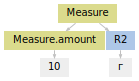

In [93]:
#правило, которому можно передать список строк morph_pipeline
Unit1 = morph_pipeline([
      'ст.л',
      'ст.ложка',
      'г',
      'гр',
      'шт',
      'столовая ложка',
      'ч.л.',
      'грамм',
      'стакан'
      ]
)
Measure_tr1 = rule(Amount, Unit1).interpretation(Measure)
parser2 = Parser(Measure_tr)
line1 = "5 ст.л. муки, 10 г муки, 5 шт помидор"
match = list(parser2.findall(line1))
spans1 = [_.span for _ in match]
show_markup(line1, spans1)
print(match[2])
print(match[1].fact)
match[1].tree.as_dot

In [0]:
def show_matches(rule, *lines):
    parser = Parser(rule) #инициализируем Parser
    for line in lines:
        matches = parser.findall(line) #у парсера есть несколько методов, findall - возвращает список matches
        matches = sorted(matches, key=lambda _: _.span)
        spans = [_.span for _ in matches]
        show_markup(line, spans)
        if matches:
            facts = [_.fact for _ in matches]
            if len(facts) == 1:
                facts = facts[0]
            display(facts)


INT = type('INT')
NOUN = gram('NOUN')
ADJF = gram('ADJF')
PRTF = gram('PRTF')
GENT = gram('gent')
DOT = eq('.')

TOKENIZER = MorphTokenizer()

##Spoon
В прошлый раз мы все строили постепенно, чтобы посмотреть, как работают отдельные фунции, предикаты и факты\
Теперь будет более системно строить парсер
(1) для начала исчислим все варианты меры "ложка"


In [80]:
Spoon = fact(
    'Spoon',
    ['type']
)


TEA = morph_pipeline([
    'ч',
    'чайн',
    'чайная',
]).interpretation(
    Spoon.type.const('чайная')
)

TABLE = morph_pipeline([
    'ст',
    'стол',
    'столовая',
]).interpretation(
    Spoon.type.const('столовая')
)

NAME = morph_pipeline([
    'л',
    'ложка'
])

SPOON = rule(
    or_(TEA, TABLE),
    DOT.optional(),
    NAME,
    DOT.optional()
).interpretation(
    Spoon
)

show_matches(
    SPOON,
    '2 Ст. ложки',
    '3 чайных л',
)

BoxMarkup('2 Ст. ложки', [Span(2, 11, None)])

Spoon(type='столовая')

BoxMarkup('3 чайных л', [Span(2, 10, None)])

Spoon(type='чайная')

#Unit